In [34]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [35]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
PREFIX = "main/tpcc"

client_sdf = spark.read.csv(f"{PREFIX}/*/client/0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

server_sdf = spark.read.csv(f"{PREFIX}/*/server/0-0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

index_sdf = server_sdf.join(client_sdf, on='prefix')\
    .withColumn("duration", col("duration").cast(T.IntegerType()))\
    .withColumn("txns", col("txns").cast(T.IntegerType()))\
    .withColumn("clients", col("clients").cast(T.IntegerType()))\
    .withColumn("rate", col("rate").cast(T.IntegerType()))\
    .withColumn("sample", col("sample").cast(T.IntegerType()))

index_sdf.toPandas()

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.1012,baseline.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.1012,baseline.conf,30,0,125,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.1012,baseline.conf,30,0,150,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.1012,baseline.conf,30,0,175,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.1012,baseline.conf,30,0,200,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/slog/main/tpcc/baseli...,1.0.1012,baseline.conf,30,0,225,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.1017,ddr_ts.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.1017,ddr_ts.conf,30,0,125,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.1017,ddr_ts.conf,30,0,150,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:///home/ctring/data/slog/main/tpcc/ddr_ts...,1.0.1017,ddr_ts.conf,30,0,175,0,10,tpcc,0,45:43:4:4:4,1,2,-1


# Throughput

In [37]:
# Extract all prefixes in the index
throughput_df = index_sdf.select("prefix", "sample").toPandas()
# Compute the throughput of each prefix
throughput_df["throughput"] = throughput_df.apply(
    lambda row: throughput(
        spark,
        row["prefix"],
        start_offset_sec=5,
        duration_sec=20
    ).first().throughput,
    axis=1
)
# Associate metadata from the index to the throughputs
throughput_df = throughput_df.merge(index_sdf.drop("sample").toPandas(), on="prefix")
# Try to cast columns to appropriate types 
throughput_df = throughput_df.convert_dtypes()

throughput_df.sort_values(by="config_name")

,prefix,sample,throughput,version,config_name,duration,txns,clients,rate,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:///home/ctring/data/slog/main/tpcc/baseli...,10,44471.19708,1.0.1012,baseline.conf,30,0,100,0,tpcc,0,45:43:4:4:4,1,2,-1
1,file:///home/ctring/data/slog/main/tpcc/baseli...,10,45557.826789,1.0.1012,baseline.conf,30,0,125,0,tpcc,0,45:43:4:4:4,1,2,-1
2,file:///home/ctring/data/slog/main/tpcc/baseli...,10,44008.979185,1.0.1012,baseline.conf,30,0,150,0,tpcc,0,45:43:4:4:4,1,2,-1
3,file:///home/ctring/data/slog/main/tpcc/baseli...,10,43756.201999,1.0.1012,baseline.conf,30,0,175,0,tpcc,0,45:43:4:4:4,1,2,-1
4,file:///home/ctring/data/slog/main/tpcc/baseli...,10,43827.04296,1.0.1012,baseline.conf,30,0,200,0,tpcc,0,45:43:4:4:4,1,2,-1
5,file:///home/ctring/data/slog/main/tpcc/baseli...,10,42651.733662,1.0.1012,baseline.conf,30,0,225,0,tpcc,0,45:43:4:4:4,1,2,-1
18,file:///home/ctring/data/slog/main/tpcc/baseli...,10,509.231684,1.0.1012,baseline.conf,30,0,1,0,tpcc,0,45:43:4:4:4,1,2,-1
14,file:///home/ctring/data/slog/main/tpcc/baseli...,10,36964.886942,1.0.1012,baseline.conf,30,0,75,0,tpcc,0,45:43:4:4:4,1,2,-1
13,file:///home/ctring/data/slog/main/tpcc/baseli...,10,25738.203174,1.0.1012,baseline.conf,30,0,50,0,tpcc,0,45:43:4:4:4,1,2,-1
12,file:///home/ctring/data/slog/main/tpcc/baseli...,10,13332.832903,1.0.1012,baseline.conf,30,0,25,0,tpcc,0,45:43:4:4:4,1,2,-1


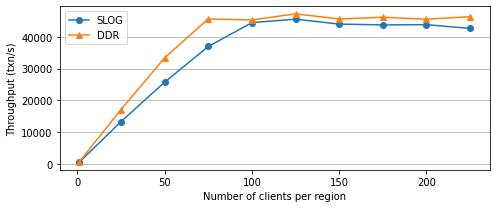

In [43]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = "clients"
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index()
pivoted["clients"] = pivoted.index
pivoted.rename(columns={"baseline.conf": "SLOG", "ddr_ts.conf": "DDR"}, inplace=True)
pivoted.columns.name = ''

ax = pivoted.plot(x="clients", xlabel="Number of clients per region", ylabel='Throughput (txn/s)', rot=0, legend=False, figsize=(7,3))

markers = ["o", "^"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

ax.legend(ax.get_lines(), pivoted.columns)

plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/tpcc-throughput.pdf')

## By Region

No handles with labels found to put in legend.


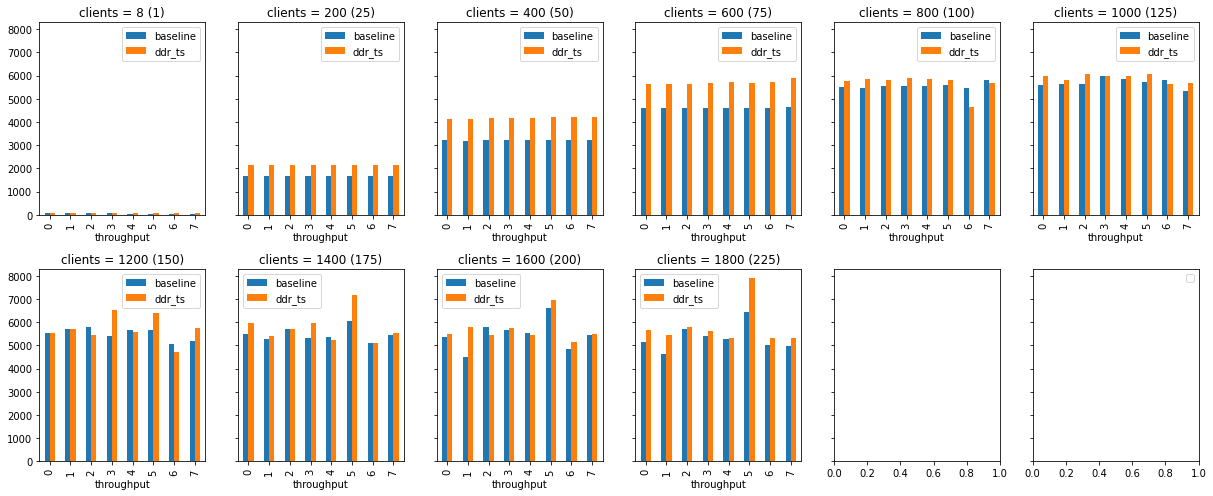

In [58]:
rows = 2
cols = 6
_, ax = plt.subplots(rows, cols, figsize=(17, 7), sharey=True)

index_df = index_sdf.toPandas()
clients_values = sorted(index_df["clients"].unique())
for i, clients in enumerate(clients_values):
    filtered = index_df.loc[index_df.clients == clients]

    baseline_prefix = filtered.loc[filtered.config_name == "baseline.conf", "prefix"].iat[0]
    baseline_sample = filtered.loc[filtered.config_name == "baseline.conf", "sample"].iat[0]
    baseline_throughput_per_region = throughput(
        spark,
        baseline_prefix,
        per_region=True,
        start_offset_sec=5,
        duration_sec=20,
    )

    ddr_ts_prefix = filtered.loc[filtered.config_name == "ddr_ts.conf", "prefix"].iat[0]
    ddr_ts_sample = filtered.loc[filtered.config_name == "ddr_ts.conf", "sample"].iat[0]
    ddr_ts_throughput_per_region = throughput(
        spark,
        ddr_ts_prefix,
        per_region=True,
        start_offset_sec=5,
        duration_sec=20,
    )

    cmp = baseline_throughput_per_region.withColumnRenamed("throughput", "baseline")\
        .join(ddr_ts_throughput_per_region.withColumnRenamed("throughput", "ddr_ts"), "machine")\
        .toPandas()\
        .sort_values("machine")
 
    r, c = i // cols, i % cols
    cmp.plot.bar(ax=ax[r, c], x="machine")

    ax[r, c].set_title(f"clients = {clients * 8} ({clients})")
    ax[r, c].set_xlabel("throughput")

plt.legend()
plt.tight_layout()

# Latency

In [59]:
prefixes = list(map(lambda r : r.prefix, index_sdf.select("prefix").collect()))
latency_sdf = latency(spark, prefixes).withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))
latency_sdf = latency_sdf.join(index_sdf, on="prefix").orderBy("clients").cache()
latency_sdf.show()

+--------------------+------+-----------+--------+----------+---------+------------------+--------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|              prefix|txn_id|coordinator|replicas|partitions|  latency|coordinator_region| version|  config_name|duration|txns|clients|rate|sample|wl:name|wl:sh_only|     wl:mix|wl:mh_zipf|wl:homes|wl:sp_partition|
+--------------------+------+-----------+--------+----------+---------+------------------+--------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|file:///home/ctri...| 22206|          6|  [0, 1]|       [3]|19.704576|                 2|1.0.1012|baseline.conf|      30|   0|      1|   0|    10|   tpcc|         0|45:43:4:4:4|         1|       2|             -1|
|file:///home/ctri...| 43605|          5|     [1]|       [2]| 7.861504|                 1|1.0.1012|baseline.conf|      30|   0|      1|   0|

## By number of clients

In [65]:
def all_client_counts(sdf):
    return sdf.select("clients")\
        .distinct()\
        .orderBy("clients")\
        .rdd.map(lambda r : r.clients)\
        .collect()


def plot_latency_per_client_count(sdf_dict):
    max_clients = 0
    for sdf in sdf_dict.values():
        max_clients = max(max_clients, len(all_client_counts(sdf)))
    
    rows, cols = compute_rows_cols(max_clients, 5)
    _, ax = plt.subplots(rows, cols, figsize=(14, 5))

    for label, sdf in sdf_dict.items():
        print(label)
        all_clients = all_client_counts(sdf)
        print("  Clients: ", end='')
        for i, clients in enumerate(all_clients):
            print(f"{clients}", end=' ')
            r, c = i // cols, i % cols

            by_clients = sdf.where(col("clients") == clients)
            plot_cdf(collect_col(sdf.where(col("clients") == clients), "latency"), ax=ax[r, c], label=label, linewidth=0)

            ax[r, c].set_title(f"clients = {clients}")
            ax[r, c].set_xlabel("latency (ms)")
            ax[r, c].legend()
        print()

SH_FILTER = F.size("replicas") == 1
MH_FILTER = F.size("replicas") > 1
LATENCY_PCT_50 = F.percentile_approx("latency", 0.5, 100000).alias("latency_50")
LATENCY_PCT_90 = F.percentile_approx("latency", 0.90, 100000).alias("latency_90")
LATENCY_PCT_95 = F.percentile_approx("latency", 0.95, 100000).alias("latency_95")
LATENCY_PCT_99 = F.percentile_approx("latency", 0.99, 100000).alias("latency_99")

LATENCY_PCT_LABELS = ["latency_50", "latency_90", "latency_95", "latency_99"]

### Single-Home

baseline
  Clients: 1 25 50 75 100 125 150 175 200 225 
ddr_ts
  Clients: 1 25 50 75 100 125 150 175 200 225 


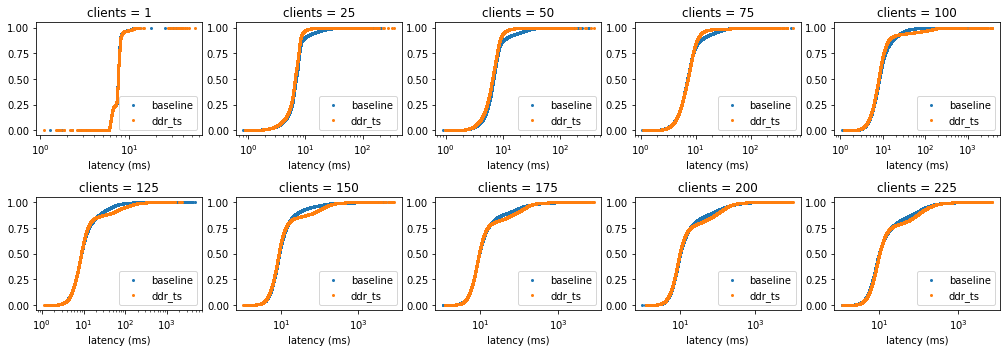

In [61]:
plot_latency_per_client_count({
    "baseline": latency_sdf.where((col("config_name") == "baseline.conf") & SH_FILTER).cache(),
    "ddr_ts": latency_sdf.where((col("config_name") == "ddr_ts.conf") & SH_FILTER).cache(),
})
plt.tight_layout()

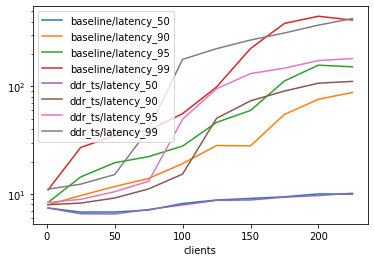

In [74]:
baseline_pct = latency_sdf.where((col("config_name") == "baseline.conf") & SH_FILTER)\
    .groupBy("clients")\
    .agg(LATENCY_PCT_50, LATENCY_PCT_90, LATENCY_PCT_95, LATENCY_PCT_99)\
    .toPandas()

ddr_ts_pct = latency_sdf.where((col("config_name") == "ddr_ts.conf") & SH_FILTER)\
    .groupBy("clients")\
    .agg(LATENCY_PCT_50, LATENCY_PCT_90, LATENCY_PCT_95, LATENCY_PCT_99)\
    .toPandas()

_, ax = plt.subplots(1, 1)

baseline_pct.plot(ax=ax, x="clients", y=LATENCY_PCT_LABELS, label=list(map(lambda s: f'baseline/{s}', LATENCY_PCT_LABELS)))
ddr_ts_pct.plot(ax=ax, x="clients", y=LATENCY_PCT_LABELS, label=list(map(lambda s: f'ddr_ts/{s}', LATENCY_PCT_LABELS)))
ax.set_yscale("log")

### Multi-Home

baseline
  Clients: 1 25 50 75 100 125 150 175 200 225 
ddr_ts
  Clients: 1 25 50 75 100 125 150 175 200 225 


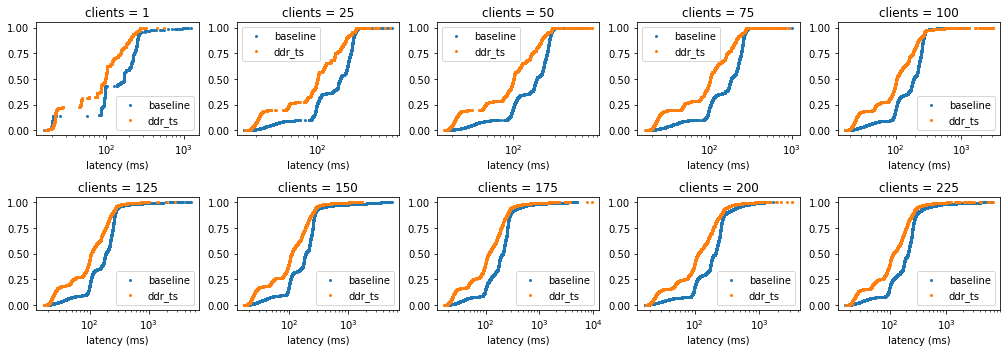

In [63]:
plot_latency_per_client_count({
    "baseline": latency_sdf.where((col("config_name") == "baseline.conf") & MH_FILTER).cache(),
    "ddr_ts": latency_sdf.where((col("config_name") == "ddr_ts.conf") & MH_FILTER).cache(),
})
plt.tight_layout()

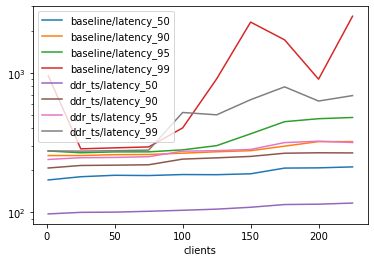

In [73]:
baseline_pct = latency_sdf.where((col("config_name") == "baseline.conf") & MH_FILTER)\
    .groupBy("clients")\
    .agg(LATENCY_PCT_50, LATENCY_PCT_90, LATENCY_PCT_95, LATENCY_PCT_99)\
    .toPandas()

ddr_ts_pct = latency_sdf.where((col("config_name") == "ddr_ts.conf") & MH_FILTER)\
    .groupBy("clients")\
    .agg(LATENCY_PCT_50, LATENCY_PCT_90, LATENCY_PCT_95, LATENCY_PCT_99)\
    .toPandas()

_, ax = plt.subplots(1, 1)

baseline_pct.plot(ax=ax, x="clients", y=LATENCY_PCT_LABELS, label=list(map(lambda s: f'baseline/{s}', LATENCY_PCT_LABELS)))
ddr_ts_pct.plot(ax=ax, x="clients", y=LATENCY_PCT_LABELS, label=list(map(lambda s: f'ddr_ts/{s}', LATENCY_PCT_LABELS)))
ax.set_yscale("log")

# By regions

In [75]:
def plot_latency_per_region(sdf_dict):
    rows = 2
    cols = 4
    _, ax = plt.subplots(rows, cols, figsize=(15, 7))

    for i in range(8):
        r, c = i // cols, i % cols
        
        for label, sdf in sdf_dict.items():
            plot_cdf(
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                ax=ax[r, c],
                label=label,
                linewidth=0,
                marker='o'
            )

        ax[r, c].set_title(f"region = {i}")
        ax[r, c].set_xlabel("latency (ms)")
        ax[r, c].legend()

In [76]:
CLIENTS = 100
baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & (col("clients") == CLIENTS)).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & (col("clients") == CLIENTS)).cache()

### Single-Home

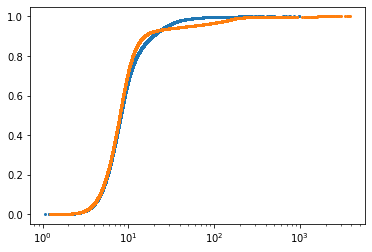

In [77]:
_, ax = plt.subplots(1, 1)
plot_cdf(collect_col(baseline_sdf.where(SH_FILTER), "latency"), ax=ax, label="baseline", linewidth=0, marker='o')
plot_cdf(collect_col(ddr_ts_sdf.where(SH_FILTER), "latency"), ax=ax, label="ddr_ts", linewidth=0, marker='o')

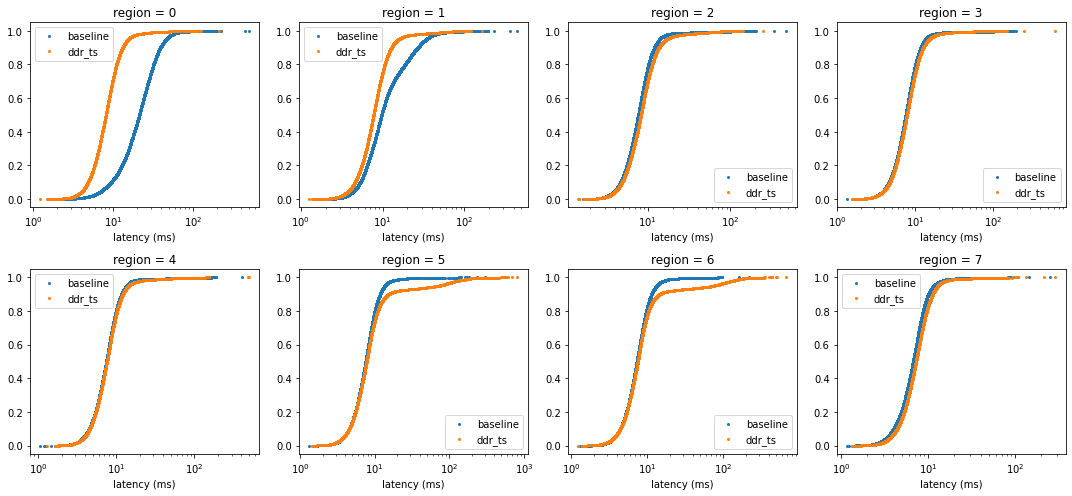

In [78]:
plot_latency_per_region({
    "baseline": baseline_sdf.where(SH_FILTER),
    "ddr_ts": ddr_ts_sdf.where(SH_FILTER),
})

plt.tight_layout()

### Multi-Home

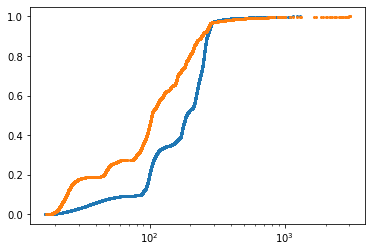

In [79]:
_, ax = plt.subplots(1, 1)
plot_cdf(collect_col(baseline_sdf.where(MH_FILTER), "latency"), label="baseline", ax=ax, linewidth=0, marker='o')
plot_cdf(collect_col(ddr_ts_sdf.where(MH_FILTER), "latency"), label="ddr_ts", ax=ax, linewidth=0, marker='o')

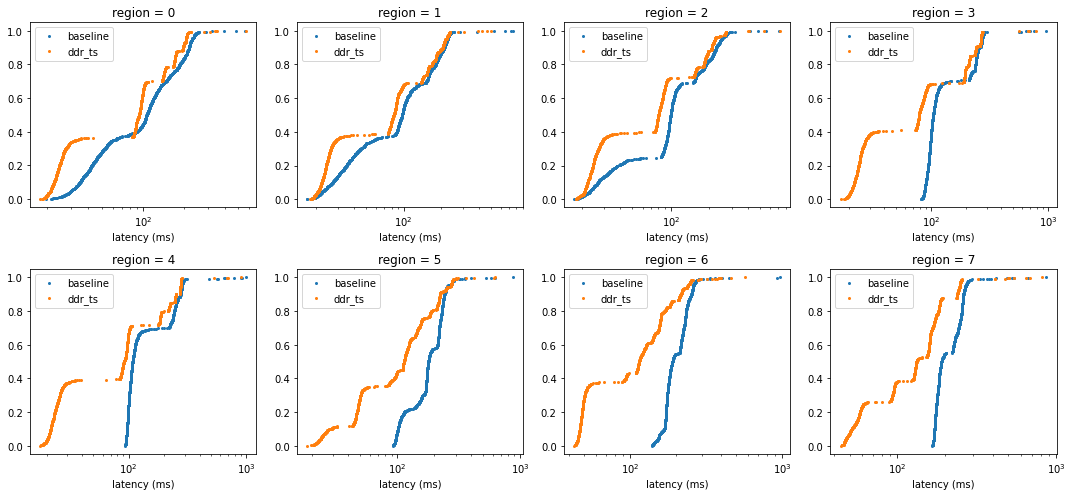

In [80]:
plot_latency_per_region({
    "baseline": baseline_sdf.where(MH_FILTER),
    "ddr_ts": ddr_ts_sdf.where(MH_FILTER),
})

plt.tight_layout()

# Ad-hoc

In [ ]:
ah_baseline_sdf = baseline_sdf.where(mh_filter)\
    .where((col("coordinator_region") == 6) & (col("latency") > 300))
ah_ddr_ts_sdf = ddr_ts_sdf.where(mh_filter)\
    .where((col("coordinator_region") == 6) & (col("latency") > 300))

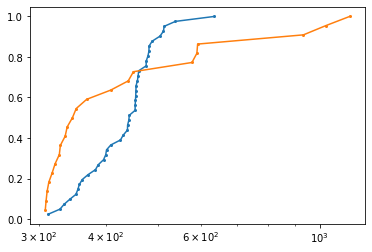

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, collect_col(ah_baseline_sdf, "latency"))
plot_cdf(ax, collect_col(ah_ddr_ts_sdf, "latency"))

In [ ]:
ah_baseline_sdf.show()

+--------------------+--------+-----------+--------+----------+----------+------------------+-------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|              prefix|  txn_id|coordinator|replicas|partitions|   latency|coordinator_region|version|  config_name|duration|txns|clients|rate|sample|wl:name|wl:sh_only|     wl:mix|wl:mh_zipf|wl:homes|wl:sp_partition|
+--------------------+--------+-----------+--------+----------+----------+------------------+-------+-------------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|file:///home/ctri...|10696718|         18|  [3, 6]|       [0]|481.007104|                 6|1.0.916|baseline.conf|      30|   0|     75|   0|    10|   tpcc|         0|45:43:4:4:4|         1|       2|             -1|
|file:///home/ctri...|10634918|         18|  [5, 6]|       [0]| 438.92096|                 6|1.0.916|baseline.conf|      30|   0|   

In [ ]:
ah_ddr_ts_sdf.show()

+--------------------+--------+-----------+--------+----------+-----------+------------------+-------+-----------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|              prefix|  txn_id|coordinator|replicas|partitions|    latency|coordinator_region|version|config_name|duration|txns|clients|rate|sample|wl:name|wl:sh_only|     wl:mix|wl:mh_zipf|wl:homes|wl:sp_partition|
+--------------------+--------+-----------+--------+----------+-----------+------------------+-------+-----------+--------+----+-------+----+------+-------+----------+-----------+----------+--------+---------------+
|file:///home/ctri...|10292920|         20|  [4, 6]|       [0]| 308.496896|                 6|1.0.916|ddr_ts.conf|      30|   0|     75|   0|    10|   tpcc|         0|45:43:4:4:4|         1|       2|             -1|
|file:///home/ctri...|10483519|         19|  [6, 7]|       [0]| 1025.88544|                 6|1.0.916|ddr_ts.conf|      30|   0|     75|